In [1]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pysph.solver.utils import load, iter_output, get_files
import pandas as pd
sns.set_style("ticks", {'axes.facecolor': '#EAEAF2', 'axes.grid': True})
file_base = '/home/prajwal/Desktop/Winter_Project/SLP-Smoothed-Particle-Hydrodynamics/SLP/Taylor Green Vortex/PySPH-Testing/'


global savefig_additional 
global figTitle1
global figTitle2
global figTitle3

In [2]:
def extract_RT(file_loc):

    from os import walk
    files = []
    for (dirpath, dirnames, filenames) in walk(file_loc):
        files.extend(filenames)
        break

    fname = ''
    for i in files:
        if i.endswith('.log'):
            fname = i

    file_loc += '/' + fname
    data = open(file_loc, 'r')
    lines = data.read()
    rt = float(lines[lines.find('Run took: ')+10:].split(' secs')[0])
    data.close()

    return rt

def custom_plot1(sph_schm, sph_schm_legend, sz=(19.2,14.4), save=False):
    n = len(sph_schm)
    fig, axs = plt.subplots(2, 2, figsize=sz)

    cnt, RT = 0, []
    for schm in sph_schm:        
        file_loc = file_base + '/Outputs/' + schm + '/results.npz'
        data = np.load(file_loc) # Read data
        leg = sph_schm_legend[schm]
        

        t, decay= data['t'], data['decay']
        
        axs[0,0].semilogy(t, decay, linewidth=2, label=leg)

        linf = data['linf']
        axs[0,1].plot(t, linf, linewidth=2, label=leg)

        l1 = data['l1']
        axs[1,0].plot(t, l1, linewidth=2, label=leg)

        p_l1 = data['p_l1']
        axs[1,1].plot(t, p_l1, linewidth=2, label=leg)

        cnt += 1
        if cnt == n:
            decay_ex =  data['decay_ex']
            axs[0,0].semilogy(t, decay_ex, '--k', linewidth=3, label="exact")

        file_loc = file_base + '/Outputs/' + schm 
        RT.append(extract_RT(file_loc))

    # Labels
    axs[1,0].set_xlabel(r't $\rightarrow$')
    axs[1,1].set_xlabel(r't $\rightarrow$')

    # Titles
    fig.suptitle(figTitle1, fontsize=24)
    axs[0,0].set_title('Max Velocity in flow vs Time', fontsize='large')
    axs[0,1].set_title(r'$L_\infty$ error vs Time', fontsize='large')
    axs[1,0].set_title(r'$L_1$ error vs Time', fontsize='large')
    axs[1,1].set_title(r'$L_1$ error for $p$ vs Time', fontsize='large')

    fig.tight_layout()
    fig.subplots_adjust(top=0.9, bottom=0.1)
    lines = []
    labels = []
    for ax in fig.axes:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
        labels.extend(axLabel)

    n += 1
    lines, labels = lines[0:n], labels[0:n]

    # Add Runtime scale
    RT = np.array(RT)
    RT_new = 100 * (RT - np.ones_like(RT)*np.min(RT)) / (np.ones_like(RT)*np.min(RT))

    for i in range(n-1):
        temp = RT_new[i]
        if temp == 0.0:
            rt = ' {' + str(round(RT[i], 1)) + 's}'
        else:
            rt = r' {' + str(round(temp, 2)) + r'$\% \uparrow$}'
        labels[i] = labels[i] + rt

    fig.legend(lines, labels, loc = 'lower center', ncol=n, prop={'size': 'medium'}, title=r'Legend {$\Delta \%$ Runtime}')

    if save == True:
        tle = file_base + '/TGV_error_plot' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)

def run_time_plot(sph_schm, sph_schm_legend, sz=(19.2,14.4), save = False):
    
    RT_x, RT_y = [], []
    for schm in sph_schm:
        file_loc = file_base + '/Outputs/' + schm 
        # Read data
        RT_y.append(extract_RT(file_loc))
        RT_x.append(sph_schm_legend[schm])
        
    # Plotting
    fig, ax = plt.subplots(figsize=sz)

    # Horizontal Bar Plot 
    ax.barh(RT_x, RT_y, height=0.4)
    # Remove axes splines 
    for s in ['top', 'bottom', 'left', 'right']: 
        ax.spines[s].set_visible(False) 
    
    # Remove x, y Ticks 
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    ax.set_xlabel(r'Run time (second) $\rightarrow$')
    
    # Add x, y gridlines 
    ax.grid(b = True, color ='black', linestyle ='-.', linewidth = 0.7, alpha = 0.2) 
    
    # Add annotation to bars 
    for i in ax.patches: 
        plt.text(i.get_width(), i.get_y()+0.2,  
                str(round((i.get_width()), 2)), 
                fontsize = 11, fontweight ='bold', 
                color ='grey') 
    
    # Add Plot Title 
    ax.set_title(figtitle2, fontsize=24) 
    if save == True:
        tle = file_base + '/TGV_runtime' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)

def jointplot_semilogx(x, y, xlabel, ylabel, title, save = False, **plot_kwargs):

    # Jointplot
    g = sns.jointplot(np.log10(x), y, **plot_kwargs)
    g.fig.suptitle(title, fontsize=20, va='baseline')

    # Generate Log - xticks
    temp = g.ax_joint.get_xticks()
    
    XT = np.arange(np.floor(min(temp)), np.ceil(max(temp)), 1)
    g.ax_joint.xaxis.set_ticks(XT)
    labels = np.round(10**XT, 6)
    g.ax_joint.xaxis.set_ticklabels(labels, minor=False);
    g.set_axis_labels(xlabel, ylabel, fontsize=16)

    if save != False:
        g.savefig(save, dpi=400) 

def custom_plot2(sph_schm, sph_schm_legend, sz=(19.2,14.4), save=False):
    from pysph.solver.utils import load, iter_output, get_files

    cnt = 0
    for schm in sph_schm:        
        file_loc = file_base + '/Outputs/' + schm
        leg = sph_schm_legend[schm]
        files = get_files(file_loc)
        data = load(files[-1])['arrays']['fluid']
        x, y, lmda, DRh = data.get('x', 'y', 'lmda', 'DRh')

        xlabel, ylabel = r'$\dfrac{|\delta \mathbf{\hat{r}_i}|}{\Delta x_i}$', r'$\lambda$'

        title = 'Taylor-Green Vortex | ' + leg
        

        if save == True:
            tle = file_base + '/TGV_jointplot-' + str(cnt) + savefig_additional + '.png' 
            cnt += 1
            jointplot_semilogx(y=lmda, x=DRh, ylabel=ylabel, xlabel=xlabel, title=title, save=tle, kind='reg', height=8)

        else:
            jointplot_semilogx(y=lmda, x=DRh, ylabel=ylabel, xlabel=xlabel, title=title, save=save, kind='reg', height=8)


def plot_loghist(x, bins = 20, ax = None, **plot_kwargs):
    if ax == None:
        ax = plt.gca()
    temp = min(x)
    if temp == 0:
        a = np.sort(x) == 0
        idx = np.where(a == False)[0][0]
        temp = np.sort(x)[idx]
        
    ax.hist(x, bins = 10 ** np.linspace(np.log10(temp), np.log10(max(x)), bins), **plot_kwargs)
    ax.set_xscale("log")
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    return(ax)

def custom_plot3(sph_schm, sph_schm_legend, bins = 20, sz=(19.2,14.4), save=False):

    fig, axs = plt.subplots(2, 2, figsize=sz)
    i = 0
    for schm in sph_schm:       
        file_loc = file_base + '/Outputs/' + schm
        leg = sph_schm_legend[schm]
        files = get_files(file_loc)
        data = load(files[-1])['arrays']['fluid']
        x, y, lmda, DRh = data.get('x', 'y', 'lmda', 'DRh')

        if i <= 1:
            plot_loghist(DRh, ax=axs[0,i%2], bins = bins)
            axs[0,i%2].set_title(leg, fontsize=20)
        else:
            plot_loghist(DRh, ax=axs[1,i%2], bins = bins)
            axs[1,i%2].set_title(leg, fontsize=20)
        i += 1
    fig.suptitle(figTitle3, fontsize=24)

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    if save == True:
        tle = file_base + '/TGV_DRH_plot' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)

def combined_loghist(file_loc, ax = None, cond = 0.0, Bins=20, **plot_kwargs):
    if ax == None:
        ax = plt.gca()

    files = get_files(file_loc)
    df = np.array([])
    cnt = 0
    for solver_data, fluid in iter_output(files, 'fluid'):
        if cnt == 0:
            cnt = 1
        else:
            df = np.concatenate([df, fluid.DRh])
            cnt += 1

    cnt -= 1
    hist, bins = np.histogram(df, bins=Bins)
    hist_norm = hist / cnt

    width = 0.9 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    #ax.bar(center, hist_norm, align='center', width=width, log=True)
    plot_loghist(df, bins=Bins, ax=ax, log=False)

    temp = (df <= cond).sum()
    res = round(temp * 100/len(df), 3)
    return res

def custom_plot4(sph_schm, sph_schm_legend, bins = 20, sz=(19.2,14.4), save=False, vlines=None):
    from pysph.solver.utils import load, iter_output, get_files

    fig, axs = plt.subplots(2, 2, figsize=sz)
    i = 0
    for schm in sph_schm:       
        file_loc = file_base + '/Outputs/' + schm
        leg = sph_schm_legend[schm]

        if i <= 1:
            r = combined_loghist(file_loc, ax=axs[0,i%2], cond=vlines[i], bins=bins)
            leg += ' {' + str(r) + '%}'
            axs[0,i%2].set_title(leg, fontsize=20)
        else:
            r = combined_loghist(file_loc, ax=axs[1,i%2], cond=vlines[i], bins=bins)
            leg += ' {' + str(r) + '%}'
            axs[1,i%2].set_title(leg, fontsize=20)
        i += 1
    fig.suptitle(figTitle3, fontsize=24)

    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    if vlines != None:
        axs[0,0].axvline(x=vlines[0],c='k', linestyle='--')
        axs[0,1].axvline(x=vlines[1],c='k', linestyle='--')
        axs[1,0].axvline(x=vlines[2],c='k', linestyle='--')
        axs[1,1].axvline(x=vlines[3],c='k', linestyle='--')

    if save == True:
        tle = file_base + '/TGV_DRH_plot' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)


In [3]:
df = pd.read_csv(file_base + 'SPH Scheme - Test - TGV.csv')
df

,Simulation Number,Scheme,PST,Kernel,nx,perturb,hdx,PST_Rh
0,0,𝛿+ SPH,True,WendlandQuintic,30,0.2,1.33,0.05
1,1,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.33,0.05
2,2,𝛿+ SPH,True,WendlandQuintic,70,0.2,1.33,0.05
3,3,𝛿+ SPH,True,WendlandQuintic,90,0.2,1.33,0.05
4,4,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.33,0.1
5,5,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.33,0.2
6,6,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.33,0.5
7,7,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.33,1
8,8,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.00,0.05
9,9,𝛿+ SPH,True,WendlandQuintic,50,0.2,1.50,0.05


In [82]:
sph_schm_legend = {
    '00': 'nx = 30',
    '01': 'nx = 50', #'Rh = 0.05', #'hdx = 1.33', 
    '02': 'nx = 70',
    '03': 'nx = 90',
    '04': 'Rh = 0.1',
    '05': 'Rh = 0.2',
    '06': 'R_coeff = 1e-5',
    '07': 'R_coeff = 1e-3',
    '08': 'hdx = 1.0',
    '09': r'$\delta^+$ - SPH', #'n_exp = 4', #'R_coeff = 1e-4', #'WendlandQuintic | hdx = 1.5', #'hdx = 1.5', 
    '10': 'hdx = 2.0',
    '11': 'QuinticSpline | hdx = 1.5',
    '12': 'Gaussian | hdx = 1.5',
    '13': 'CubicSpline | hdx = 1.5',
    '14': r'$\delta^+$ - SPH (No PST)',
    '15': r'$\delta$ - SPH',
    '16': 'EDAC',
    '17': 'R_coeff = 1e-2',
    '18': 'R_coeff = 5e-5',
    '19': 'R_coeff = 5e-4',
    '20': 'R_coeff = 2e-5',
    '21': 'R_coeff = 2e-4',
    '22': 'n_exp = 3',
    '23': 'n_exp = 2',
    '24': 'n_exp = 6',
    '25': r'$\delta^+$ - SPH (CS, n = 3, R = 1e-4)',

}

sph_schm = ['16','14', '09', '25',]
vl = [0.05, 0.05, 0.05, 0.05]
#vl = [0.05, 0.1, 0.2, 0.5]
name = 'scheme-2'    


##############
savefig_additional = '_' + name
temp = ' | Variation with (' + name + ')'
figTitle1 = 'Taylor-Green Vortex - Error Plot' + temp
figtitle2 = 'Taylor-Green Vortex - Runtimes' + temp
figTitle3 = r'Taylor-Green Vortex - Histogram $\dfrac{|\delta \mathbf{\hat{r}_i}|}{\Delta x_i}$' + temp
##############

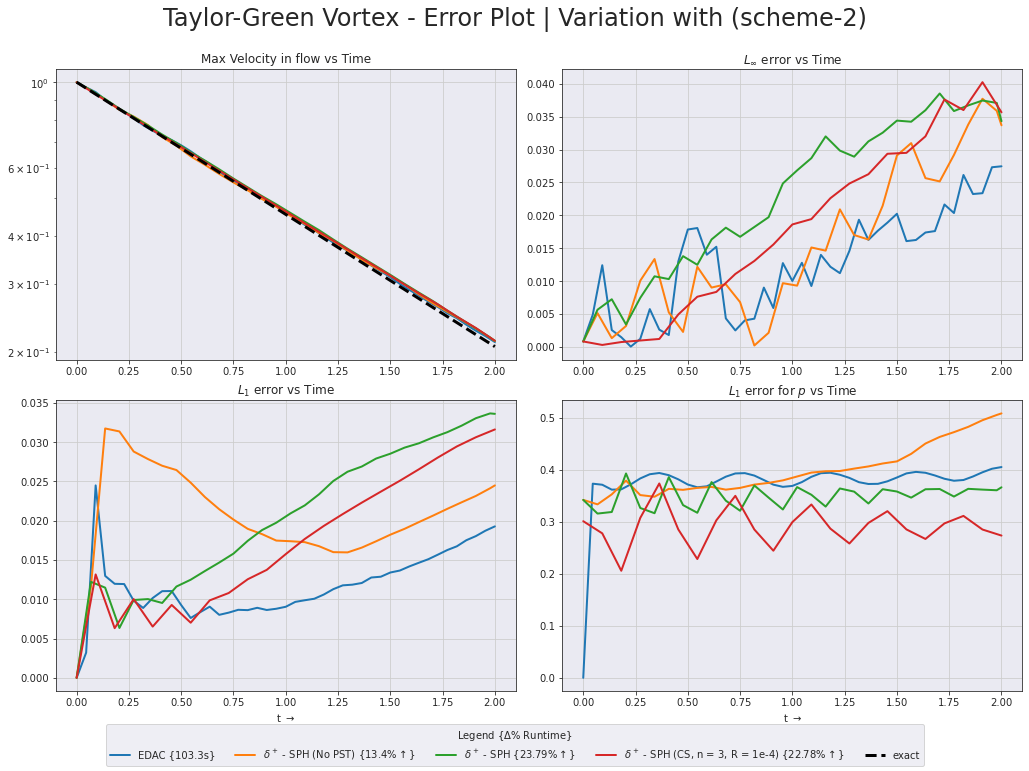

In [83]:
custom_plot1(sph_schm, sph_schm_legend, save=False, sz=(14.4,10.8))

In [70]:
custom_plot4(sph_schm, sph_schm_legend, vlines=vl, save=False, sz=(14.4, 10.8))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [48]:
#run_time_plot(sph_schm, sph_schm_legend, save=False)
#custom_plot2(sph_schm, sph_schm_legend, save=False)
#custom_plot3(sph_schm, sph_schm_legend, bins=25,save=False)